# Data Scientist Salary Stats using 2016 H1-B Petition Data

In [ ]:
## all imports
from IPython.display import HTML
import numpy as np
import urllib2
import bs4 #this is beautiful soup
import time
import operator
import socket
import cPickle


import ssl
import math
import re

from pandas import Series
import pandas as pd
from pandas import DataFrame
from collections import Counter
from operator import itemgetter

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context("talk")
sns.set_style("white")

from secret import *

Beautiful Soup is a Python library for pulling data out of HTML and XML files. It works with parsers to provide idiomatic ways of navigating, searching, and modifying the parse tree. It saves hours or days of work going through the HTML tag.

For the H1-B Salary data, I used http://visadoor.com/h1bvisa-database. I'm only looking at the job titles with 'Data Scientist' in it. You can modify the URL below to search your job title.

In [159]:
# Fixed url for H1-B Sponsored job details containing 'data scientist' keyword
url = 'http://visadoor.com/h1b/index?company=&job=Data+Scientist&decision_date=&year=2016&page=1&submit=Search'
# read the website
source = urllib2.urlopen(url).read()
# parse html code
bs_tree = bs4.BeautifulSoup(source,"html.parser")

In [98]:
# Find the number of pages or search
num_petitions = bs_tree.findAll('h4')[2].get_text().split()
num_pages = int(math.ceil(float(num_petitions[3])/float(num_petitions[1])))

In [ ]:
# This analysis is mainly based on salary,so I removed petitions with no salary reported

job_details = []

for i in range(1,num_pages):
    url = 'http://visadoor.com/h1b/index?company=&job=Data+Scientist&decision_date=&year=2016&page=' + str(i) + '&submit=Search'
    html_page = urllib2.urlopen(url).read() 
    bs_tree = bs4.BeautifulSoup(html_page)
    table = bs_tree.find('table', attrs={'class':'table table-bordered table-striped table-hover'})


    rows = table.findAll('tr')
    for row in rows[13:]:
        cols = row.findAll('td')
        cols = [ele.text.strip() for ele in cols]
        cols = [cols[index] for index in [0,2,4,5]]
        # Some of the rows has salary listed as 'Per Hour'. I multiply that number with avg. number of work hours i.e. 2087
        if cols[3].split()[2].split('/')[1] == 'Hour':
            cols[3] = max(float(cols[3].split()[0].replace(',','')),float(cols[3].split()[2].split('/')[0].replace(',','')))
            cols[3] = cols[3]*2087.143
        else:
            cols[3] = max(float(cols[3].split()[0].replace(',','')),float(cols[3].split()[2].split('/')[0].replace(',','')))
        
        # This part of the code looks for job state and city. This info is not specified  on the main page.
        # It goes to each petition page and finds this information
        
        url = 'http://visadoor.com/h1bvisa-' + cols[0] + '/' + cols[2].replace(',','').lower()
        source = urllib2.urlopen(url).read()
        soup = bs4.BeautifulSoup(source,"html.parser")
        table_new = soup.find('table', attrs={'class':'table table-bordered table-striped table-hover'})
        row = table_new.findAll('tr')
        cols.append(row[20].findAll('td')[1].get_text())
        cols.append(row[21].findAll('td')[1].get_text())
        
        job_details.append([ele for ele in cols if ele]) # Get rid of empty values
        


In [234]:
# Create a pandas dataframe 
DSH1BJobDetails = pd.DataFrame(job_details, columns = ['Case_Number','Employer_Name', 'Job_Title', 'Wage_Rate','City','State'])
DSH1BJobDetails = DSH1BJobDetails.iloc[:,[0,1,4,5,2,3]]
DSH1BJobDetails[10:20]


,Case_Number,Employer_Name,City,State,Job_Title,Wage_Rate
10,I-200-16264-869491,"Renee Systems, Inc",ALEXANDRIA,VA,BIG DATA SME (DATA SCIENTIST),95000.0
11,I-200-16263-331959,"Renee Systems, Inc",ALEXANDRIA,VA,BIG DATA SME (DATA SCIENTIST),95000.0
12,I-200-16263-477125,Tastemade Inc.,SANTA MONICA,CA,DATA SCIENTIST,195000.0
13,I-200-16260-102888,Salesforce.com Inc.,SAN FRANCISCO,VA,DATA SCIENTIST,138507.0
14,I-200-16256-335109,"Infor (us), Inc.",ATLANTA,GA,DATA SCIENTIST,102000.0
15,I-200-16259-328436,"Ancestry.com Operations, Inc.",SAN FRANCISCO,CA,SENIOR DATA SCIENTIST,150000.0
16,I-200-16259-656346,"Kohl's Department Stores, Inc.",MILPITAS,CA,SENIOR DATA SCIENTIST,130000.0
17,I-200-16259-619979,"Ancestry.com Operations, Inc.",SAN FRANCISCO,CA,SENIOR DATA SCIENTIST,150000.0
18,I-200-16256-966432,"Uber Technologies, Inc.",SAN FRANCISCO,CA,DATA SCIENTIST,115000.0
19,I-200-16258-724351,Microsoft Corporation,REDMOND,WA,DATA SCIENTIST,115000.0


In [217]:
print 'Mean Salary of Data Scientist in USA: ' + '$' + str(int(DSH1BJobDetails['Wage_Rate'].mean()))
print 'Median Salary of Data Scientist in USA: ' + '$' + str(int(DSH1BJobDetails['Wage_Rate'].median()))


Mean Salary of Data Scientist in USA: $115434
Median Salary of Data Scientist in USA: $115000


## Distribution of Data Scientist Salary in USA

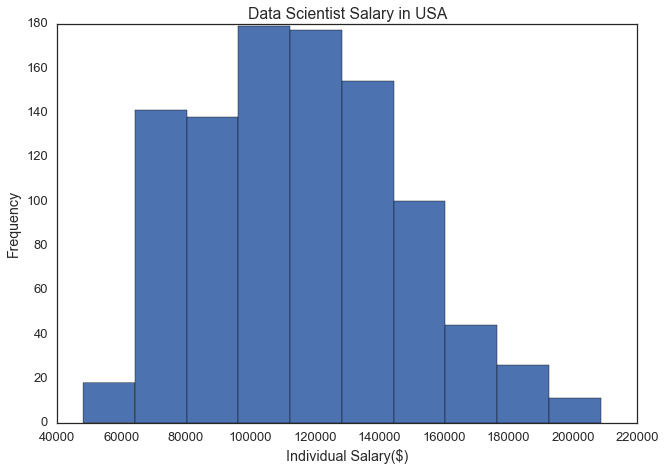

In [231]:
ax = DSH1BJobDetails.Wage_Rate.hist()
plt.xlabel("Individual Salary($)")
plt.ylabel("Frequency")
plt.title("Data Scientist Salary in USA")
plt.grid(False)

## Which State offers the highest salary?

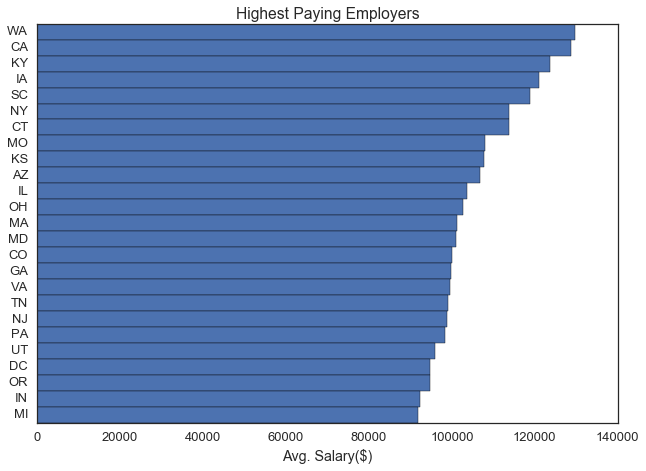

In [236]:
byState = []
byStatedict ={}
avg_wage = {}

for i in range(len(DSH1BJobDetails)):
    byState.append((str(DSH1BJobDetails.iloc[i]['State']), DSH1BJobDetails.iloc[i]['Wage_Rate']))

for a in byState:
    byStatedict.setdefault(a[0], []).append(a[1])
for k,v in byStatedict.items():
    avg_wage[k] = int(sum(v)/ float(len(v)))
    
c = Counter(avg_wage).items()
c.sort(key=itemgetter(1),reverse = True)
c = c[:25]
labels, values = zip(*c)

indexes = np.arange(len(labels))
width =1
plt.barh(indexes, values, width)
plt.ylim(25,0)
plt.yticks(indexes + width*0.5, labels)
plt.xlabel("Avg. Salary($)")
plt.title("Highest Paying Employers")
plt.show()

# This number can be skewed because of very few petitions in certain states but higher pay




# Which employer pays the most?

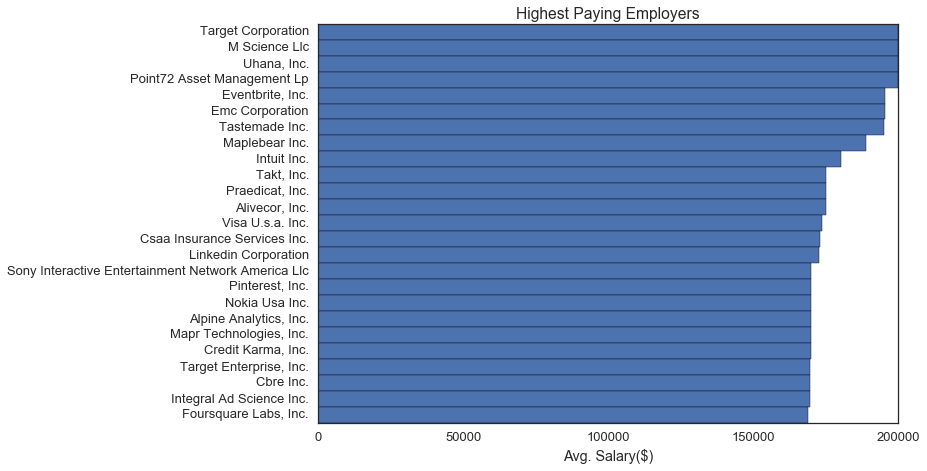

In [237]:
byEmployer = []
byEmployerdict ={}
avg_wage = {}

for i in range(len(DSH1BJobDetails)):
    byEmployer.append((str(DSH1BJobDetails.iloc[i]['Employer_Name']), DSH1BJobDetails.iloc[i]['Wage_Rate']))

for a in byEmployer:
    byEmployerdict.setdefault(a[0], []).append(a[1])
for k,v in byEmployerdict.items():
    avg_wage[k] = int(sum(v)/ float(len(v)))
    
c = Counter(avg_wage).items()
c.sort(key=itemgetter(1),reverse = True)
c = c[:25]
labels, values = zip(*c)

indexes = np.arange(len(labels))
width =1
plt.barh(indexes, values, width)
plt.ylim(25,0)
plt.yticks(indexes + width*0.5, labels)
plt.xlabel("Avg. Salary($)")
plt.title("Highest Paying Employers")
plt.show()